In [13]:
pip show yfinance

Name: yfinance
Version: 0.2.66
Summary: Download market data from Yahoo! Finance API
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: C:\Users\RONIKET ROY\anaconda3\Lib\site-packages
Requires: beautifulsoup4, curl_cffi, frozendict, multitasking, numpy, pandas, peewee, platformdirs, protobuf, pytz, requests, websockets
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import math
import random
import matplotlib.pyplot as plt

#Configurations
#-------------------

TICKERS=["AAPL", "MSFT", "AMZN", "GOOG"]
START="04-09-2012"
END="01-09-2017"
SEQ_LEN=30
PRED_HORIZON=1
BATCH_SIZE=64
EPOCHS=3
DEVICE="cuda" if torch.cuda.is_available() else "cpu"
T_DIFFUSION=50
LR=1e-3
SEED=42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [8]:
#Downloading prices and computing indicators
aapl = pd.read_csv("AAPL.csv", usecols=["Date", "Adj Close"])
msft = pd.read_csv("MSFT.csv", usecols=["Date", "Adj Close"])
amzn = pd.read_csv("AMZN.csv", usecols=["Date", "Adj Close"])
goog = pd.read_csv("GOOG.csv", usecols=["Date", "Adj Close"])

aapl.rename(columns={"Adj Close": "AAPL"}, inplace=True)
msft.rename(columns={"Adj Close": "MSFT"}, inplace=True)
amzn.rename(columns={"Adj Close": "AMZN"}, inplace=True)
goog.rename(columns={"Adj Close": "GOOG"}, inplace=True)

df = aapl.merge(msft, on="Date").merge(amzn, on="Date").merge(goog, on="Date")

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

def compute_indicators(price_df):
    returns=price_df.pct_change().fillna(0)
    sma5=price_df.rolling(window=5).mean().pct_change().fillna(0)
    sma10=price_df.rolling(window=10).mean().pct_change().fillna(0)
    vol10=price_df.pct_change().rolling(window=10).std().fillna(0)
    mom5=price_df.pct_change(periods=5).fillna(0)

    T=len(price_df)
    N=len(price_df.columns)
    features=[]
    for df in [returns, sma5, sma10, vol10, mom5]:
        features.append(df.values.reshape(T,N,1))
    X=np.concatenate(features, axis=2)
    return X, price_df.index, price_df.columns

prices=df
prices.head(10)
X_features, dates, tickers=compute_indicators(prices)

print("Price data and technical indicators matrix shape:", X_features.shape)


Price data and technical indicators matrix shape: (1258, 4, 5)


In [10]:
#Building Adjacency graph
def relation_graph(price_df):
    returns=price_df.pct_change().dropna()
    corr=returns.corr()
    A=(corr.values+1.0)/2.0
    np.fill_diagonal(A, 0.0)
    row_sums=A.sum(axis=1, keepdims=True)+1e-8
    A_norm=A/row_sums
    return A_norm.astype(np.float32)

A=relation_graph(prices)
print("Adjacency matrix for the graph :", A)

Adjacency matrix for the graph : [[0.         0.3421771  0.32074282 0.3370801 ]
 [0.31895038 0.         0.32940647 0.35164315]
 [0.30192536 0.33266154 0.         0.36541313]
 [0.30573654 0.3421718  0.35209167 0.        ]]


In [12]:
#Dataset Class
class StockDataset(Dataset):
    def __init__(self, X_features, price_df, seq_len=30, pred_horizon=1, scaler=None):
        self.X=X_features
        self.T, self.N, self.F=X_features.shape
        self.seq_len=seq_len
        self.pred_horizon=pred_horizon
        returns=price_df.pct_change().fillna(0).values
        self.y=returns
        self.indices=[t for t in range(seq_len-1, self.T-pred_horizon)]
        self.scaler=scaler
        if scaler is None:
            flat=self.X.reshape(-1, self.F)
            self.scaler=StandardScaler().fit(flat)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        t=self.indices[idx]
        seq_slice=self.X[t-(self.seq_len-1): t+1]
        seq_scaled=(seq_slice-self.scaler.mean_.reshape(1,1,-1))/(self.scaler.scale_.reshape(1,1,-1)+1e-8)
        target=self.y[t+self.pred_horizon]
        return torch.tensor(seq_scaled, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

dataset=StockDataset(X_features, prices, seq_len=SEQ_LEN, pred_horizon=PRED_HORIZON)
train_size=int(0.8*len(dataset))
test_size=len(dataset)-train_size
train_set, test_set=torch.utils.data.random_split(dataset,[train_size, test_size])
train_loader=DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader=DataLoader(test_set, batch_size=32, shuffle=False)
            

In [14]:
#MaTCHS denoiser
class RelationalSelfAttention(nn.Module):
    def __init__(self, dim, num_heads, N):
        super().__init__()
        self.num_heads=num_heads
        self.dim=dim
        self.head_dim=dim//num_heads
        self.qkv=nn.Linear(dim, dim*3)
        self.out=nn.Linear(dim, dim)
        self.N=N

    def forward(self, x, adj):
        B,S,N,D=x.shape
        qkv=self.qkv(x)
        q,k,v=torch.chunk(qkv, 3, dim=-1)
        q=q.view(B,S,N, self.num_heads, self.head_dim).permute(0,3,1,2,4)
        k=k.view(B,S,N, self.num_heads, self.head_dim).permute(0,3,1,2,4)
        v=v.view(B,S,N, self.num_heads, self.head_dim).permute(0,3,1,2,4)

        attn_out=[]
        scale=1.0/math.sqrt(self.head_dim)
        for s in range(S):
            qi=q[:,:,s,:,:]; ki=k[:,:,s,:,:]; vi=v[:,:,s,:,:]
            scores=torch.einsum("bhnd,bhmd->bhnm", qi, ki)*scale
            adj_tensor = torch.tensor(adj, dtype=torch.float32, device=DEVICE)
            bias=adj_tensor.unsqueeze(0).unsqueeze(0)
            scores=scores+bias
            A=torch.softmax(scores, dim=-1)
            out=torch.einsum("bhnm,bhmd->bhnd", A, vi)
            out_comb=out.permute(0,2,1,3).reshape(B,N,self.num_heads*self.head_dim)
            attn_out.append(out_comb.unsqueeze(1))

        attn_cat=torch.cat(attn_out, dim=1)
        return self.out(attn_cat)

class SimpleMaTCHS(nn.Module):
    def __init__(self, N, feature_dim, model_dim=64, num_heads=4,seq_len=SEQ_LEN):
        super().__init__()
        self.N=N; self.F=feature_dim; self.D=model_dim
        self.input_proj=nn.Linear(feature_dim, model_dim)
        self.temb=nn.Embedding(T_DIFFUSION+1, model_dim)
        self.attn=RelationalSelfAttention(model_dim, num_heads, N)
        self.ff=nn.Sequential(nn.Linear(model_dim, model_dim), nn.ReLU(), nn.Linear(model_dim, model_dim))
        self.out_head=nn.Linear(model_dim,1)
        self.seq_pool=nn.AdaptiveAvgPool1d(1)

    def forward(self, x_seq, t, adj):
        B,S,N,F=x_seq.shape
        h=self.input_proj(x_seq)
        tem=self.temb(t).view(B,1,1,-1)
        h=h+tem
        h2=self.attn(h,adj)
        h=h+h2+self.ff(h)
        hperm=h.permute(0,2,3,1)
        hflat=hperm.reshape(B*N, self.D, S)
        pooled=self.seq_pool(hflat).squeeze(-1)
        pooled=pooled.view(B,N,self.D)
        out=self.out_head(pooled).squeeze(-1)

        return out
            

In [16]:
#Diffusion setup
def q_sample(x0, t, noise, alpha_bars):
    a=alpha_bars[t].reshape(-1,1)
    return torch.sqrt(a)*x0+torch.sqrt(1.0-a)*noise

def get_alphas(T):
    beta=np.linspace(1e-4,0.02, T)
    alpha=1.0-beta
    alpha_bar=np.cumprod(alpha)
    return torch.tensor(alpha,dtype=torch.float32), torch.tensor(alpha_bar, dtype=torch.float32)

In [18]:
#Training loop setup
def train_diffusion(dataloader, model, adj, epochs=EPOCHS):
    model.to(DEVICE)
    optimizer=torch.optim.Adam(model.parameters(), lr=LR)
    alpha, alpha_bar=get_alphas(T_DIFFUSION)
    alpha_bar=alpha_bar.to(DEVICE)
    for ep in range(epochs):
        epoch_loss=0.0
        for seq, target in dataloader:
            seq=seq.to(DEVICE)
            target=target.to(DEVICE)
            B=seq.shape[0]
            t=torch.randint(0,T_DIFFUSION, (B,), device=DEVICE, dtype=torch.long)
            noise=torch.randn_like(target)
            x_t=q_sample(target, t, noise, alpha_bar)
            pred_noise=model(seq, t, torch.tensor(adj, device=DEVICE))
            loss=nn.MSELoss()(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        print(f"Epoch{ep+1}/{epochs}, loss:{epoch_loss/len(dataloader):.6f}")

    return model, alpha_bar, alpha

In [20]:
#Initiating the model
N=X_features.shape[1]; F=X_features.shape[2]
model=SimpleMaTCHS(N=N, feature_dim=F)
model_trained, alpha_bar, alpha=train_diffusion(train_loader, model, A, epochs=EPOCHS)

C:\Users\RONIKET ROY\AppData\Local\Temp\ipykernel_11568\3433589599.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_tensor = torch.tensor(adj, dtype=torch.float32, device=DEVICE)


Epoch1/3, loss:1.177309
Epoch2/3, loss:1.077079
Epoch3/3, loss:1.036588


In [21]:
alpha.dim(), alpha_bar.shape

(1, torch.Size([50]))

In [22]:
# Sampling and evaluation
def sample_from_model(model, seq_context, adj, n_samples=20, alpha_bar=None):
    model.to(DEVICE); model.eval()
    samples=[]
    B = seq_context.shape[0]
    with torch.no_grad():
        for s in range(n_samples):
            #starting from random noise
            x_t=torch.randn_like(seq_context[:,-1,:])
            x_t = x_t.mean(dim=-1) 
            
            #reverse diffusion process
            for tt in reversed(range(T_DIFFUSION)):
                t_tensor=torch.tensor([tt]*B, device=DEVICE, dtype=torch.long)

                #predicting noise using denoiser (MaTCHS-based model)
                pred_noise=model(seq_context, t_tensor, adj)

                #Diffusion reverse update rule
                if tt>0:
                    beta_t=1-alpha[tt]
                    alpha_t=alpha[tt]
                    alpha_bar_t=alpha_bar[tt]
                    noise=torch.randn_like(x_t)
                    x_t=(1/torch.sqrt(alpha_t))*(x_t-(beta_t/torch.sqrt(1-alpha_bar_t))*pred_noise) + torch.sqrt(beta_t)*noise
                else:
                    alpha_t=alpha[tt]
                    alpha_bar_t=alpha_bar[tt]
                    x_t=(1/torch.sqrt(alpha_t))*(x_t-((beta_t)/torch.sqrt(1-alpha_bar_t))*pred_noise)
        samples.append(x_t.cpu().numpy())
    return np.array(samples)

In [23]:
def mean(array):
    total=0.0
    count=0
    for x in array:
        total=total+x
        count=count+1
    return total/count if count>0 else float('nan')

In [11]:
import statistics as st
from sklearn.metrics import f1_score
def evaluate_model(model, seq_context, adj, true_future, alpha_bar):
    preds=sample_from_model(model, seq_context, adj, n_samples=50, alpha_bar=alpha_bar)
    mean_pred=preds.mean(axis=0)

    #Metrics
    mse_elements=(mean_pred-true_future.cpu().numpy())**2
    mae_elements=np.abs(mean_pred-true_future.cpu().numpy())
    mse=mean(mse_elements)
    mae=mean(mae_elements)

    #F1 score
    y_true=(true_future>0).to(torch.int).flatten()
    y_pred=(mean_pred>0).astype(int).flatten()

    f1=f1_score(y_true, y_pred, zero_division=0)

    #Directional accuracy 
    acc_elements=np.sign(mean_pred)==np.sign(true_future.cpu().numpy())
    acc=mean(acc_elements)

    return {"MSE": mse, "MAE": mae, "Directional Accuracy": acc, "F1-Score": f1}

In [240]:
# Evaluation
metrics_list = []

for seq, y_true in test_loader:
    seq, y_true = seq.to(DEVICE), y_true.to(DEVICE)
    # seq=seq.unsqueeze(2)
    # seq=seq.expand(-1,-1,2,-1)
    results = evaluate_model(model, seq, A, y_true, alpha_bar=alpha_bar)
    metrics_list.append(results)

# Average metrics
final_metrics = {k: mean([m[k] for m in metrics_list]) for k in metrics_list[0].keys()}
print("\nFinal Evaluation Metrics on Test Set:")
for k, v in final_metrics.items():
    print(f"{k}: {v}")


Final Evaluation Metrics on Test Set:
MSE: [0.92740816 1.0039232  0.82796943 0.94713736]
MAE: [0.77775747 0.80435914 0.717329   0.7731008 ]
Directional Accuracy: [0.4609375  0.45667614 0.56392045 0.48899148]
F1-Score: 0.5209243843736325


In [53]:
for seq, y_true in test_loader:
    seq, y_true = seq.to(DEVICE), y_true.to(DEVICE)
    preds=sample_from_model(model, seq, A, n_samples=50, alpha_bar=alpha_bar)
    print(preds)

[[[ 2.30100441e+00 -2.26452246e-01 -2.09261194e-01 -5.94954751e-02]
  [ 7.30123460e-01  2.38876605e+00 -6.54427350e-01 -1.43425971e-01]
  [ 2.03513086e-01  4.07346368e-01 -2.12932897e+00  2.48663276e-01]
  [ 1.64841786e-01 -3.02007437e-01 -9.92825091e-01 -1.03110515e-01]
  [-2.04151416e+00 -4.35019910e-01  7.45741069e-01 -1.06787765e+00]
  [ 9.81999993e-01  2.54066408e-01 -1.30928111e+00  8.62714797e-02]
  [ 1.65021706e+00 -1.15719903e+00  1.49695516e+00  7.50040174e-01]
  [ 5.18340409e-01 -6.78992942e-02 -1.92926037e+00  1.27825046e+00]
  [-8.38693857e-01 -1.56928504e+00  2.22080961e-01  5.68792701e-01]
  [-8.15171719e-01 -5.69845401e-02 -9.46286097e-02  2.02696949e-01]
  [-7.90913224e-01  8.35257769e-01 -8.27881098e-01  5.98321617e-01]
  [-4.48354512e-01  1.14731121e+00  1.73358214e+00 -2.91776180e-01]
  [-9.74252522e-01  1.74296451e+00 -7.65970126e-02  1.10622346e+00]
  [-1.99597704e+00 -7.82228932e-02 -5.27614020e-02  7.49004304e-01]
  [ 3.51398379e-01 -1.15413822e-01 -1.68054235e+

In [84]:
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
def density_evaluation_model(model, seq_context, adj, true_future, alpha_bar, stock_idx):
    preds=sample_from_model(model, seq_context, adj, n_samples=50, alpha_bar=alpha_bar)

    #using kde for estimating pdf from samples
    pred_values=preds[:, stock_idx].flatten()
    kde=gaussian_kde(preds[:, stock_idx].flatten())
    x_vals=np.linspace(min(pred_values), max(pred_values), 200)
    pdf_vals=kde(x_vals)

    #Fitting a Gaussian for comparison
    mu=mean(preds[:, stock_idx].flatten())
    sigma=np.std(preds[:, stock_idx].flatten())
    gaussian_pdf=norm.pdf(x_vals, mu, sigma)

    #plotting
    plt.figure(figsize=(8,5))
    plt.plot(x_vals, pdf_vals, label="Predicted PDF (from samples)", linewidth=2)
    plt.plot(x_vals, gaussian_pdf, '--', label = "Gaussian fit", color='red')

    plt.title("Distribution of diffusion model prediction for $y_{t+1}$")
    plt.xlabel("Predicted values")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

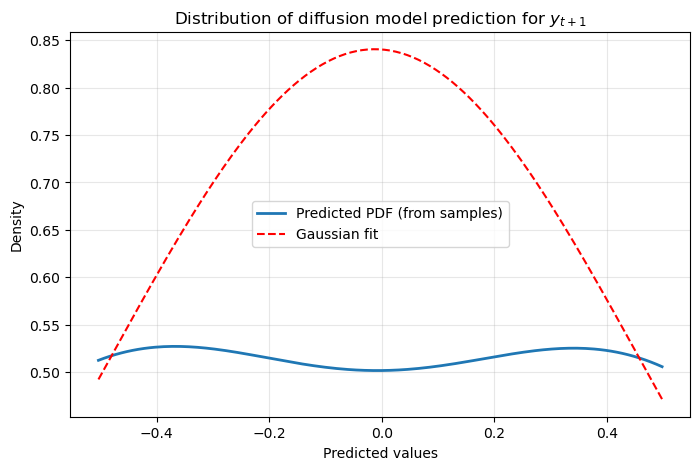

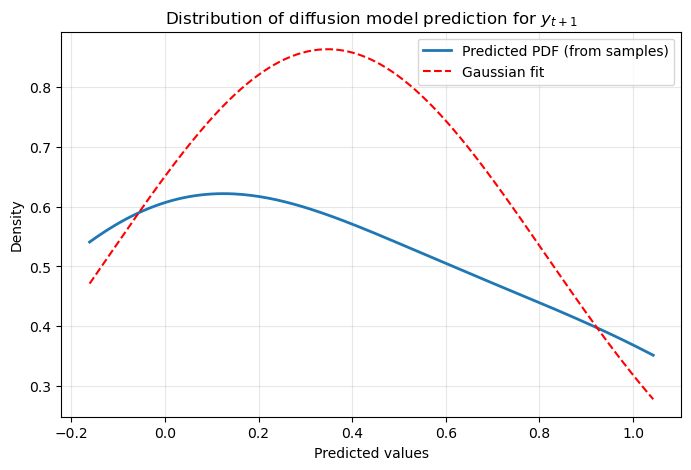

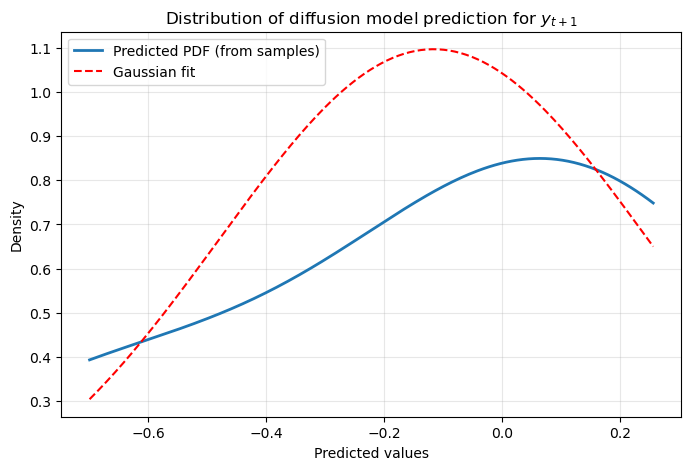

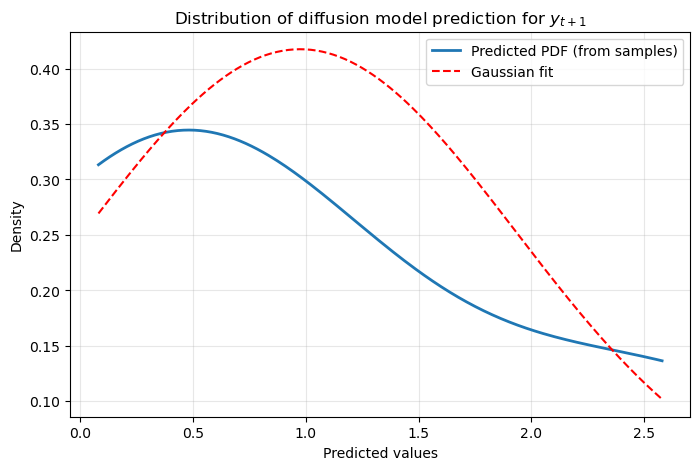

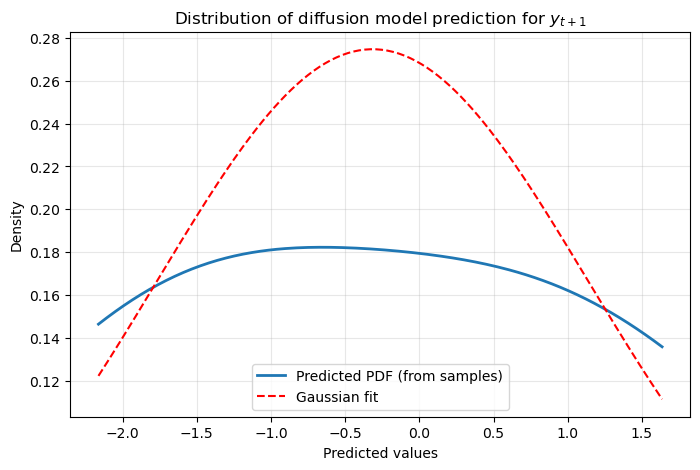

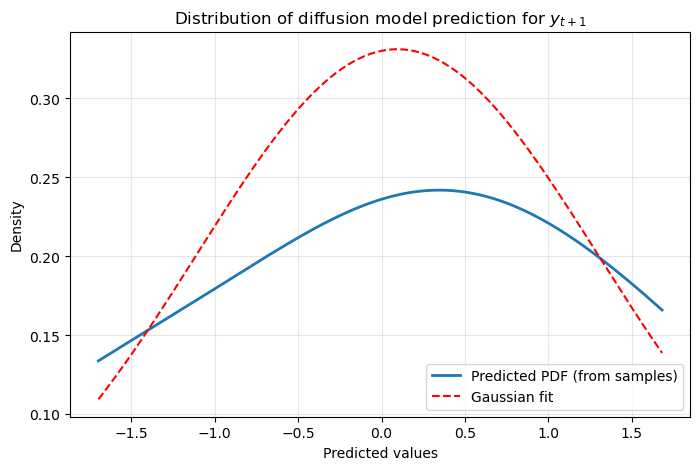

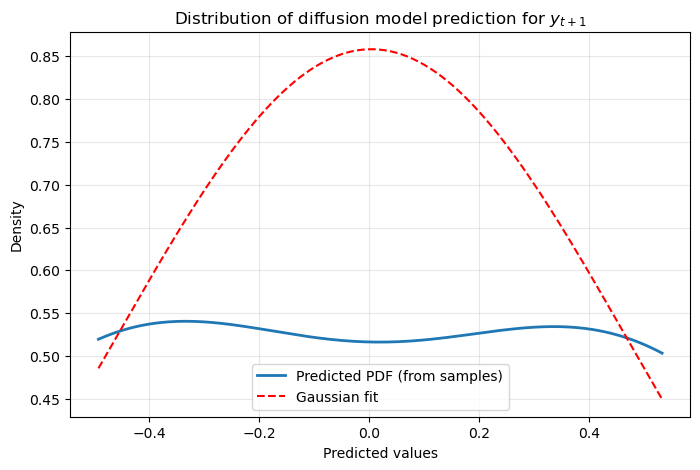

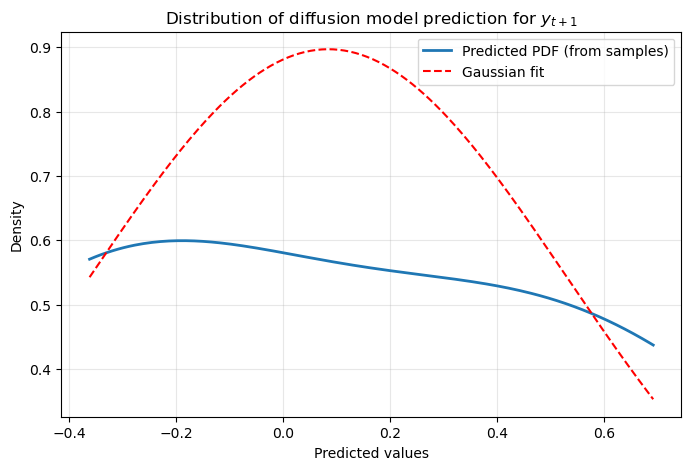

In [86]:
#distribution for AAPL
for seq, y_true in test_loader:
    seq, y_true = seq.to(DEVICE), y_true.to(DEVICE)
    # seq=seq.unsqueeze(2)
    # seq=seq.expand(-1,-1,2,-1)
    density_evaluation_model(model, seq, A, y_true, alpha_bar=alpha_bar, stock_idx=0)